In [1]:
import os
import re
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lxml import html

In [2]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # Single-column figure.

In [3]:
regex_time = re.compile(r'((?P<day>\d+?) days? )?'
                        r'((?P<hour>\d+?) hours? )?'
                        r'((?P<minutes>\d+?) minutes? )?'
                        r'((?P<seconds>\d+?) seconds?)?')

In [4]:
def get_execution_time(task_id):
    with urllib.request.urlopen(f'https://proteomics2.ucsd.edu/ProteoSAFe/'
                                f'status.jsp?task={task_id}') as f_url:
        execution_time_str = html.fromstring(f_url.read()).xpath(
            '//th[text()="Execution Time"]/following-sibling::td/text()')[0]
        match = re.match(regex_time, execution_time_str)
        execution_time = 0
        if match is not None:
            seconds, minutes, hours, days = match.group(
                'seconds', 'minutes', 'hour', 'day')
            if seconds is not None:
                execution_time += int(seconds)
            if minutes is not None:
                execution_time += 60 * int(minutes)
            if hours is not None:
                execution_time += 60 * 60 * int(hours)
            if days is not None:
                execution_time += 24 * 60 * 60 * int(days)
        return execution_time

In [5]:
def get_num_spectrum_files(task_id, extension=None):
    with urllib.request.urlopen(f'https://proteomics2.ucsd.edu/ProteoSAFe/'
                                f'status.jsp?task={task_id}') as f_url:
        num_files_str = html.fromstring(f_url.read()).xpath(
            '//th[text()="Spectrum Files"]/following-sibling::td/'
            'descendant::*/text()')
        return sum([1 for line in num_files_str
                    if extension is None
                    or line.strip().lower().endswith(extension.lower())])

In [6]:
data_dir = '../data/UCDavis_combined'
metadata = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))

In [7]:
runtimes = [
    get_execution_time(
        deconvolution_link[deconvolution_link.rfind('=') + 1:])
    for deconvolution_link in metadata['GNPS deconvolution link']
]

In [8]:
num_files = [
    get_num_spectrum_files(
        deconvolution_link[deconvolution_link.rfind('=') + 1:], '.cdf')
    for deconvolution_link in metadata['GNPS deconvolution link']
]

In [9]:
metadata['runtime'] = np.asarray(runtimes) / 60
metadata['num_files'] = num_files

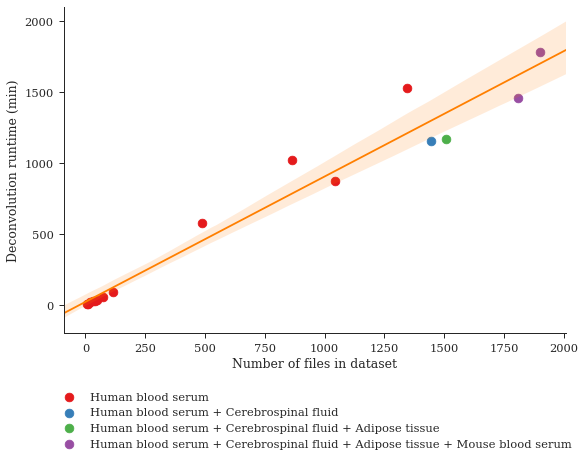

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

for sample_type in metadata['Uberon/sample type'].unique():
    sample_runtimes = metadata[metadata['Uberon/sample type'] == sample_type]
    ax.scatter(sample_runtimes['num_files'],
               sample_runtimes['runtime'],
               s=75, label=sample_type)
sns.regplot('num_files', 'runtime', metadata, scatter=False,
            color=sns.color_palette('Set1')[4], ax=ax)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

ax.set_xlabel('Number of files in dataset')
ax.set_ylabel('Deconvolution runtime (min)')

sns.despine()

plt.savefig('deconvolution_runtime.svg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

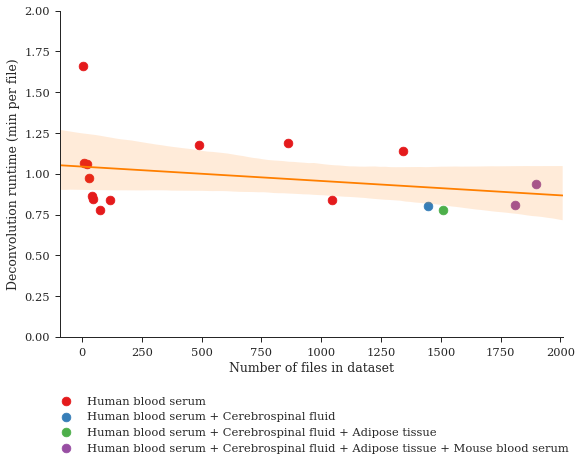

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))

metadata['runtime_per_file'] = metadata['runtime'] / metadata['num_files']
for sample_type in metadata['Uberon/sample type'].unique():
    sample_runtimes = metadata[metadata['Uberon/sample type'] == sample_type]
    ax.scatter(sample_runtimes['num_files'],
               sample_runtimes['runtime'] / sample_runtimes['num_files'],
               s=75, label=sample_type)
sns.regplot('num_files', 'runtime_per_file', metadata, scatter=False,
            color=sns.color_palette('Set1')[4], ax=ax)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

ax.set_xlabel('Number of files in dataset')
ax.set_ylabel('Deconvolution runtime (min per file)')

ax.set_ylim(0, 2)

sns.despine()

plt.savefig('deconvolution_runtime_per_file.svg', dpi=300, bbox_inches='tight')
plt.show()
plt.close()